Import All Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense,Dropout
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense,Dropout
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

Prepare Data from CSV

In [2]:
data = pd.read_csv("merged_datasets.csv",header="infer")
data = data.drop(columns=["HUMAN PLAYER POSITION (X) metres","HUMAN PLAYER POSITION (Y) metres","INITITAL VELOCITY OF SHUTTELCOCK(m/s)","INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)","SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)","OUT_OF_COURT_SHOTS"])
data = data.rename(columns={"SHUTTLECOCK POSITIION IN AIR(X ) metres":"X","SHUTTLECOCK POSITIION IN AIR(Y) metres":"Y","SHUTTLECOCK POSITIION IN AIR(Z) metres":"Z"})

Split Dataset

In [ ]:
numShots = data["SHOT_ID"].max()
print(numShots)
trainsetSize = int(numShots*0.7)
print(trainsetSize)
testsetSize = numShots-trainsetSize
traindata = data.loc[data["SHOT_ID"]<= trainsetSize]
testdata = data.loc[data["SHOT_ID"] > trainsetSize]
print(traindata.head())
print(testdata.head())



Normalize Data

In [ ]:
scale = MinMaxScaler()
traindata[["X","Y","Z"]] = scale.fit_transform(traindata[["X","Y","Z"]])
testdata[["X","Y","Z"]] = scale.fit_transform(testdata[["X","Y","Z"]])
print(traindata.head())
print(testdata.head())

Sequence Function

In [4]:
def prepare_data(data, sequence_length):
    X = []
    Y = []
    for shot_id in data['SHOT_ID'].unique():
        shot_data = data.loc[data['SHOT_ID'] == shot_id][['X', 'Y', 'Z']].values
        for i in range(len(shot_data) - sequence_length):
            sequence = shot_data[i:i+sequence_length]
            X.append(sequence)
            Y.append(shot_data[i+sequence_length])
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

Create Sequence for test and train

In [ ]:
sequence_length =15
X_train, Y_train = prepare_data(traindata, sequence_length)
print(X_train.dtype,Y_train.dtype)



X_test, Y_test = prepare_data(testdata, sequence_length)
print(X_test)


Load Model If Exist Else Skip

In [6]:
lstmModel = load_model('Run3.h5')

Configure LSTM Model

In [ ]:
lstmModel = Sequential()
lstmModel.add(LSTM(32,activation='relu',input_shape=(sequence_length,3), return_sequences=True))
lstmModel.add(LSTM(192, activation='relu',return_sequences=True))
lstmModel.add(LSTM(64, activation='tanh'))
lstmModel.add(Dense(3))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lstmModel.compile(loss='mean_squared_error',optimizer=optimizer)

In [ ]:
lstmModel = Sequential()
lstmModel.add(LSTM(100,activation='relu',input_shape=(sequence_length,3), return_sequences=True))
lstmModel.add(LSTM(100, activation='relu',return_sequences=True))
lstmModel.add(LSTM(100, activation='relu'))
lstmModel.add(Dense(3))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lstmModel.compile(loss='mean_squared_error',optimizer=optimizer)

In [ ]:
lstmModel = Sequential()
lstmModel.add(LSTM(192,activation='relu',input_shape=(sequence_length,3), return_sequences=True))
lstmModel.add(LSTM(160, activation='relu',return_sequences=True))
lstmModel.add(LSTM(96, activation='tanh'))
lstmModel.add(Dense(3))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
lstmModel.compile(loss='mean_squared_error',optimizer=optimizer)

In [ ]:
lstmModel = Sequential()
lstmModel.add(LSTM(224,activation='relu',input_shape=(sequence_length,3), return_sequences=True))
lstmModel.add(LSTM(160, activation='relu',return_sequences=True))
lstmModel.add(LSTM(160, activation='relu',return_sequences=True))
lstmModel.add(LSTM(96, activation='tanh',return_sequences=True))
lstmModel.add(LSTM(160, activation='tanh'))
lstmModel.add(Dense(3))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
lstmModel.compile(loss='mean_squared_error',optimizer=optimizer)
lstmModel.fit(X_train, Y_train, epochs=10, validation_data=(X_test,Y_test))

Train model with training dataset sequence

In [ ]:
lstmModel.fit(X_train, Y_train, epochs=20, validation_data=(X_test,Y_test))

Test Model with test dataset sequence

In [ ]:
Y_pred = lstmModel.predict(X_test)
#Y_pred = scale.inverse_transform(Y_pred)


850/850 [==============================] - 13s 15ms/step


Get Mean Squared Error

In [ ]:
mse_values = []
rmse_values = []

mse = lstmModel.evaluate(X_test, Y_test)
rmse = np.sqrt(mse)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

mse_values.append(mse)
rmse_values.append(rmse)

# Save MSE and RMSE values to a file
with open('mse_rmse_values.txt', 'a') as file:
    for mse, rmse in zip(mse_values, rmse_values):
        file.write(f'{mse},{rmse}\n')

# Read the saved MSE and RMSE values from the file
mse_values = []
rmse_values = []

with open('mse_rmse_values.txt', 'r') as file:
    for line in file:
        mse, rmse = line.strip().split(',')
        mse_values.append(float(mse))
        rmse_values.append(float(rmse))

print(mse_values)
# Plotting the MSE and RMSE values
iterations = range(1, len(mse_values) + 1)

plt.plot(iterations, mse_values, label='MSE')
plt.plot(iterations, rmse_values, label='RMSE')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.show()

Save Model

In [ ]:
print("Saving Model")
lstmModel.save('100-100-100.h5')
print("Model Saved")

Plotting

In [ ]:
Y_test = scale.inverse_transform(Y_test)

In [ ]:
print(Y_test)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(Y_test[:,0], Y_test[:,1], Y_test[:,2], color='b', label='Actual')
ax.scatter(Y_pred[:,0], Y_pred[:,1], Y_pred[:,2], color='r',label='Predicted')
plt.show()

Recursive Prediction

In [7]:
def recurcivePredict(dataArr,predictedTrajectory):
  predictedCord = lstmModel.predict(dataArr)
  #print(predictedCord[0][2])
  if predictedCord[0][2] > 0 and predictedCord[0][0] > dataArr[0][14][0]:
    dataArr = np.delete(dataArr,0,1)
    dataArr = np.append(dataArr,[predictedCord],axis=1)
    predictedTrajectory = np.append(predictedTrajectory,[predictedCord],axis=1)
    return recurcivePredict(dataArr,predictedTrajectory)
  else:
    return predictedTrajectory

# def recurcivePredict(dataArr):
#   predictedCord = lstmModel.predict(dataArr)
#   print(predictedCord[0][2])
#   if predictedCord[0][2] > 0 and predictedCord[0][0] > dataArr[0][-1][0]:
#     dataArr = np.append(dataArr,[predictedCord],axis=1)
#     return recurcivePredict(dataArr)
#   else:
#     return dataArr

# initialInput = []
# initialInput.append(testdata.iloc[40:55][['X', 'Y', 'Z']].values)
# initialInput = np.array(initialInput)


# trajectory = recurcivePredict(initialInput,initialInput)
# print(trajectory)



In [ ]:
def predictTrajectory(startIndex, shotid):
  testinput = []

  testinput.append(data.loc[data['SHOT_ID'] == shotid][['X', 'Y', 'Z']].values)
  count = len(testinput[0])
  print(count)
  for i in range(startIndex,count):
    testinput = np.array(testinput)
    testdata = [testinput[0,:][i-15:i]]
    testdata = np.array(testdata)
    trajectory = recurcivePredict(testdata,testdata)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Predicted Trajectory at {i}")
    ax.scatter(testinput[0,:,0], testinput[0,:,1], testinput[0,:,2], color='b', label='Actual')
    ax.scatter(trajectory[0,:,0], trajectory[0,:,1], trajectory[0,:,2], color='r',label='Predicted')
    plt.show()
    time.sleep(5)

predictTrajectory(65,417)

Comparing Recursive prediction

In [ ]:
testinput = []
testinput.append(data.loc[data['SHOT_ID'] == 461][['X', 'Y', 'Z']].values)
testinput = np.array(testinput)
print(testinput)

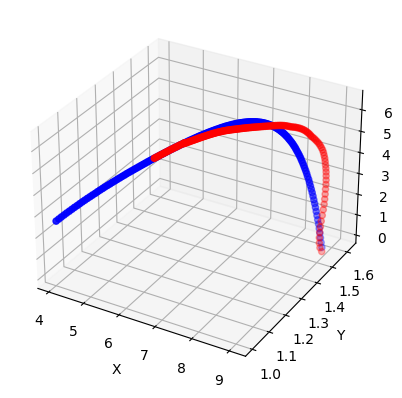

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(testinput[0,:,0], testinput[0,:,1], testinput[0,:,2], color='b', label='Actual')
ax.scatter(trajectory[0,:,0], trajectory[0,:,1], trajectory[0,:,2], color='r',label='Predicted')
plt.show()